<h1 align="center"> Ensemble Techniques

#### `Import needed libraries`

In [1]:
import pandas as pd
import numpy as np
import random 
import os

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

#### `Random SEED`

In [2]:
def set_seed(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(1)

#### `Import the DATA`

In [3]:
df = pd.read_csv('train.csv')

#### `Data Pre-Processing`

In [4]:
df.Age = df.Age.fillna(df.Age.mean())
df.Cabin = df.Cabin.fillna('X').map(lambda x: x[0].strip())
df.Ticket = df.Ticket.fillna('X').map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'X')

fare_map = df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
df.Fare = df.Fare.fillna(df.Pclass.map(fare_map['Fare']))
df.Fare = np.log1p(df.Fare)

df.Embarked = df.Embarked.fillna('X')
df.Name = df.Name.map(lambda x: x.split(',')[0])

df.isna().max()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [5]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [6]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(df[onehot_cols])
label_encoded_df = df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)
target_df = df['Survived']

df = pd.concat([onehot_encoded_df, label_encoded_df, numerical_df, target_df], axis=1)

#split the data
X, y = df.drop('Survived', axis=1), df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### `Modeling`

In [7]:
# Preprocessing, fitting, making predictions and scoring for every model:
models_results = {'min_score':{},'max_score':{},'mean_score':{},'std_dev':{}}

kfolds = 5  # it is better to be 1/(size of testing test)
split = StratifiedKFold(n_splits=kfolds, shuffle=True)

### Decision Tree

In [8]:
# Hypermarameters tuning using Gridsearch
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf':  np.arange(2, 5, dtype=int)
}

cls = DecisionTreeClassifier()
DT_model = GridSearchCV(estimator=cls,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)
DT_model.fit(X_train, y_train)
print(DT_model.best_params_)

{'max_depth': 3, 'min_samples_leaf': 2}


In [9]:
t_model = DecisionTreeClassifier(max_depth=DT_model.best_params_['max_depth'],
                                 min_samples_leaf=DT_model.best_params_['min_samples_leaf'])

dt_cv_results = cross_val_score(t_model, 
                                X, y, 
                                cv=split,
                                scoring="accuracy",
                                n_jobs=-1)

#To find the average of all the accuracies.
min_score = round(min(dt_cv_results)*100, 4)
models_results['min_score']['DT'] = min_score

#To find the max accuracy of all the accuracies.
max_score = round(max(dt_cv_results)*100, 4)
models_results['max_score']['DT'] = max_score

#To find the min accuracy of all the accuracies.
mean_score = round(np.mean(dt_cv_results)*100, 4)
models_results['mean_score']['DT'] = mean_score

# let's find the standard deviation of the data to see degree of variance in the results obtained by our model.
std_dev = round(np.std(dt_cv_results), 4)
models_results['std_dev']['DT'] = std_dev

print(f"DT cross validation accuarcy score: {mean_score} +/- {std_dev} (std) ---> min: {min_score}, max: {max_score}")

DT cross validation accuarcy score: 80.8091 +/- 0.0426 (std) ---> min: 73.5955, max: 86.5169


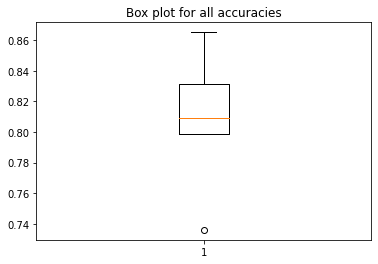

In [10]:
plt.title('Box plot for all accuracies')
plt.boxplot(dt_cv_results);

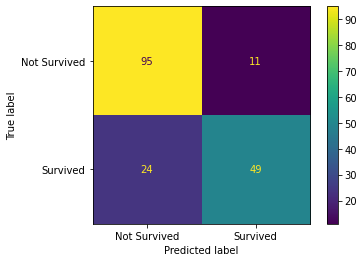

In [11]:
cm = confusion_matrix(y_test, 
                      DT_model.best_estimator_.predict(X_test),
                      labels=DT_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Survived','Survived'])
disp.plot()
plt.show()

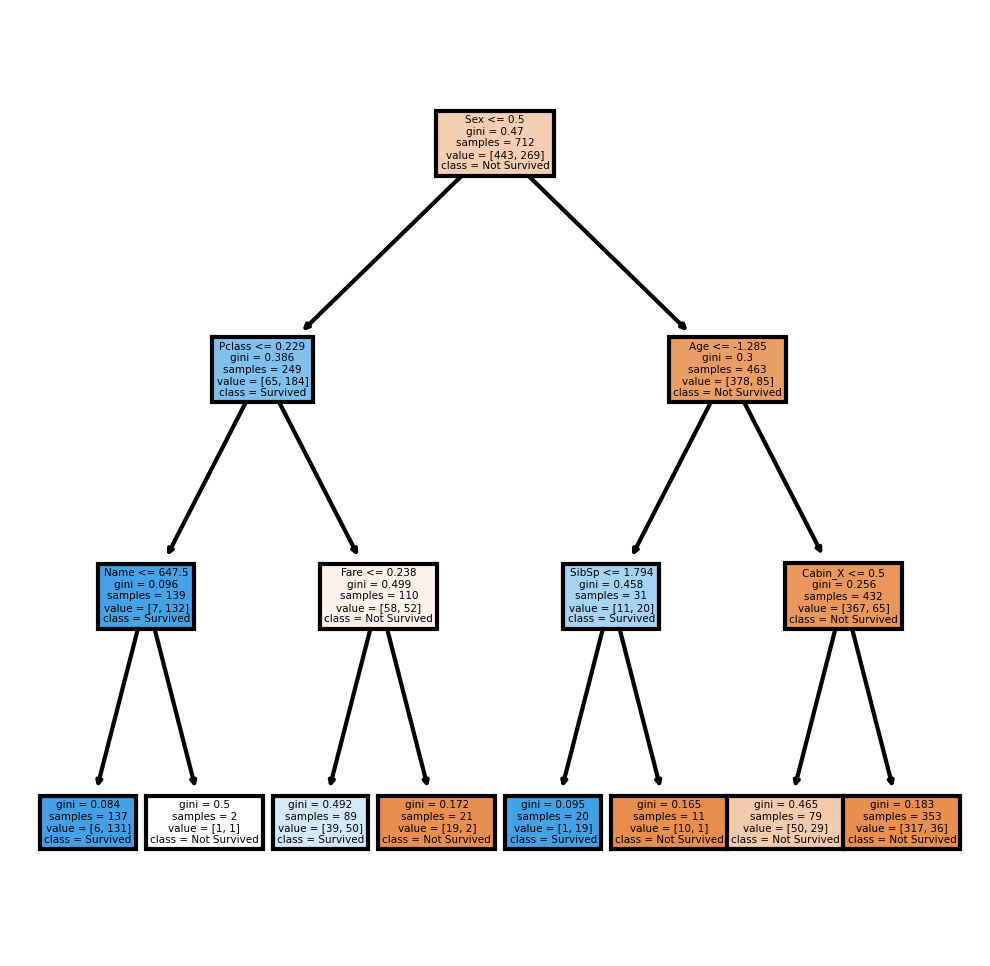

In [18]:
# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

fig = plot_tree(DT_model.best_estimator_,
                feature_names = df.columns, 
                class_names=['Not Survived','Survived'],
                filled = True,
                rounded=False,
                precision=3)
plt.savefig('tree_high_dpi', dpi=400)

**DT limitations :**
- The nodes that are deep in the tree, will only see a small subset of the data and make splits on these small subsets. 
- The chances that these subsets don’t represent the real distribution of the data increase by depth, and so does the chance of overfitting. 
- Another limitation of decision trees is that they do not optimize an overall loss function. Decision trees are trained **greedy**, which means that they minimize loss at every node. However, minimizing loss at a node level does not guarantee a minimal loss at a tree level.

**DT Advantages :**
- A decision tree does not require normalization of data 
- Requires requires less effort for data preparation during pre-processing (Null values)
- A decision tree does not require scaling 
- Easy to explain and interpret

**DT Disadvantages :**
- Prone to overfitting
- Very sensitive to the small change in the data
- Is a weak learner, so we can use Random Forest
- A lot of feature engineering may be required to make a DT mdoel

## Let's try other Ensemble algorithms 
- An ensemble technique combines weak learners in order to get a strong one.
- Usually, weak learner is a **Stump**(A simple tree with just a single split and two terminal nodes)
- Training a weak learner on the data results in two types of errors:

    1) `Variance related errors`, and can be handeled by Bagging(Bootstrap Aggregation) algorithms like:
    <ul><ul><li>Random Forest</ul></ul>
    
    2) `Bias related errors`, and can be handeled by Boosting algorithms like:
    <ul><ul><li>AdaBoost (Adaptive Boosting)
        <li>Gradient Boosting</ul></ul>


### 1) Bagging
- An ensemble technique like voting techniques but each model is trained on a subset of the data and are sampled randomly:
    - **Bagging:** If sampling with replacement.
    - **Pasting:** If sampling without replacement.


- We can also sample the features:
    - **Random Patches:** If sampling both training instances and features. 
    - **Random Subspaces:** If sampling only features and use all training instances.
    
    
- Bagging allows multiple similar models with high variance are averaged to decrease variance.
- The boostrapped trees are independent from each other.
- Random Forest is an example of Bagging algorithm.

**1.1 Random Forest:**    
- Random forest builds multiple decision trees(Weak leaners) and combines them together to get a more accurate and stable prediction.
- Advantages
    - Reduced risk of overfitting
    - Provides flexibility, it can handle both regression and classification tasks with a high degree of accuracy.
    - Easy to determine feature importance, there are a few ways to evaluate feature importance:
       - Gini importance 
       - Mean decrease in impurity (MDI)
       - Permutation importance, a.k.a. mean decrease accuracy (MDA)
- Disadvantages
    - Time-consuming process
    - Requires more resources
    - More complex

In [19]:
# Hypermarameters tuning using Gridsearch
parameters = {
    'max_depth': np.arange(5, 8, dtype=int),
    'min_samples_leaf':  np.arange(5, 8, dtype=int),
    'n_estimators': np.arange(100, 500, 100),
}

cls = RandomForestClassifier()
RF_model = GridSearchCV(estimator=cls,
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1,
                     verbose=1)
RF_model.fit(X_train, y_train)
print(RF_model.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 400}


In [20]:
t_model = RandomForestClassifier(max_depth=RF_model.best_params_['max_depth'],
                                 min_samples_leaf=RF_model.best_params_['min_samples_leaf'])

rf_cv_results = cross_val_score(t_model, 
                                X, y, 
                                cv=split,
                                scoring="accuracy",
                                n_jobs=-1)

#To find the average of all the accuracies.
min_score = round(min(rf_cv_results)*100, 4)
models_results['min_score']['RF'] = min_score

#To find the max accuracy of all the accuracies.
max_score = round(max(rf_cv_results)*100, 4)
models_results['max_score']['RF'] = max_score

#To find the min accuracy of all the accuracies.
mean_score = round(np.mean(rf_cv_results)*100, 4)
models_results['mean_score']['RF'] = mean_score

# let's find the standard deviation of the data to see degree of variance in the results obtained by our model.
std_dev = round(np.std(rf_cv_results), 4)
models_results['std_dev']['RF'] = std_dev

print(f"RF cross validation accuarcy score: {mean_score} +/- {std_dev} (std) ---> min: {min_score}, max: {max_score}")

RF cross validation accuarcy score: 81.1449 +/- 0.0311 (std) ---> min: 75.8427, max: 85.3933


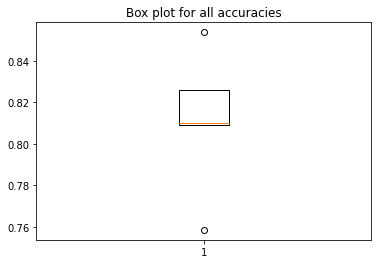

In [21]:
plt.title('Box plot for all accuracies')
plt.boxplot(rf_cv_results);

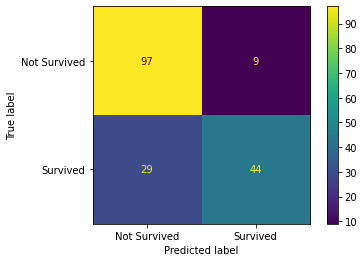

In [22]:
cm = confusion_matrix(y_test, 
                      RF_model.best_estimator_.predict(X_test),
                      labels=RF_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Survived','Survived'])
disp.plot()
plt.show()

### 2) Boosting
- Boosting is another ensemble method, it fits consecutive trees, usually random samples, and at each step, the objective is to solve net error from the prior trees.
- Boosting builds multiple incremental models to decrease the bias, while keeping variance small.
- Each tree is grown using information from previous tree.

**2.1 AdaBoost:**
- In contrary to Bagging, here each model(Classifier/Regressor) has different weight assigned to it based on the model's performance.
- Weights are also assigned to the observations at the end of every round, so that wrongly predicted observations have increased weights, resulting in their probability of beeing sampled with the next model sampling.

- The error rate of a classifier is given by:
<img src="images/adaboost1.jpg"></img>
Where  wj is weight assigned to each observation of training set Di.
- The importance of classifier is given by:
<img src="images/adaboost2.jpg"></img>
- The mechanism of updating weights to observation is:
<img src="images/adaboost3.jpg"></img>

The function exp(-alpha(i)) reduces the weight of correctly classified observation and exp(alpha(i))  increases the weight of misclassified observation, thus, increasing their chance of getting picked.  zj is the normalization factor that is used to reassign weights of observation such that all weights sum up to 1.

The final prediction of each observation is made by aggregating the weighted average of the prediction made by each classifier. AdaBoost might result in overfitting. Hence, no. of trees should be checked and restricted.

In [23]:
# Hypermarameters tuning using Gridsearch
parameters = {
    'n_estimators': np.arange(100, 600, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.9, 1]
}

cls = AdaBoostClassifier(DecisionTreeClassifier(**DT_model.best_params_))
ada_model = GridSearchCV(estimator=cls,
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=10,
                         n_jobs=-1,
                         verbose=1)
ada_model.fit(X_train, y_train)
print(ada_model.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'learning_rate': 0.01, 'n_estimators': 400}


In [24]:
t_model = AdaBoostClassifier(**ada_model.best_params_)

ada_cv_results = cross_val_score(t_model, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)

#To find the average of all the accuracies.
min_score = round(min(ada_cv_results)*100, 4)
models_results['min_score']['AdaBoost'] = min_score

#To find the max accuracy of all the accuracies.
max_score = round(max(ada_cv_results)*100, 4)
models_results['max_score']['AdaBoost'] = max_score

#To find the min accuracy of all the accuracies.
mean_score = round(np.mean(ada_cv_results)*100, 4)
models_results['mean_score']['AdaBoost'] = mean_score

# let's find the standard deviation of the data to see degree of variance in the results obtained by our model.
std_dev = round(np.std(ada_cv_results), 4)
models_results['std_dev']['AdaBoost'] = std_dev

print(f"AdaBoost cross validation accuarcy score: {mean_score} +/- {std_dev} (std) ---> min: {min_score}, max: {max_score}")

AdaBoost cross validation accuarcy score: 79.4639 +/- 0.0187 (std) ---> min: 77.095, max: 82.5843


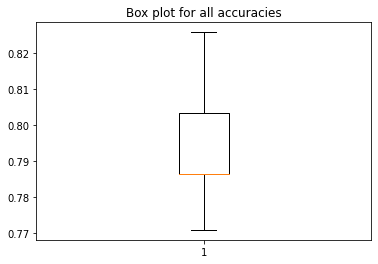

In [25]:
plt.title('Box plot for all accuracies')
plt.boxplot(ada_cv_results);

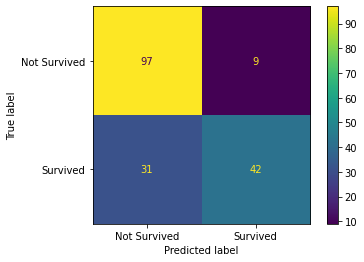

In [26]:
cm = confusion_matrix(y_test, 
                      ada_model.best_estimator_.predict(X_test),
                      labels=ada_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Survived','Survived'])
disp.plot()
plt.show()

**2.2 Gradient Boosting Machine(GBM):**
- Here, the residuals of the current classifier becomes the input for the next classifier on which the trees are built (additive model).
- The residuals are captured in a step-by-step manner by the classifiers, in order to capture the maximum variance within the data.
- To lower the variance of these methods, they're restricted by the learning rate.

- Gradient boosting trees is recurrently defined as a set of M:
<img src="images/gb1.jpg"></img>
$Fm(x)$ is an iterative boost of the model, by adding a decision tree $hm(x)$ to previous iteration of the model $Fm−1(x)$. The tree $hm(x)$ is trained on the residuals of $Fm−1(x)$. Residuals are the difference with the true labels $y$ and the predictions of the model $^y$.


- The importance of classifier is given by:
<img src="images/gb2.jpg"></img>
Intuitively this makes a lot of sense. We missed a few spots in our previous model $Fm−1(x)$ and therefore we let the next model $hm(x)$ focus on those spots. And by iterating a few times, we will approach closer to $y$ until convergence.

<img src="images/gradientboosting.png"></img>

In [27]:
# Hypermarameters tuning using Gridsearch
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf':  np.arange(2, 5, dtype=int),
    'learning_rate': [0.05, 0.1, 0.5, 0.9]
}

cls = GradientBoostingClassifier()
gb_model = GridSearchCV(estimator=cls,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1,
                        verbose=1)
gb_model.fit(X_train, y_train)
print(gb_model.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
{'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 2}


In [28]:
t_model = GradientBoostingClassifier(**gb_model.best_params_)

gb_cv_results = cross_val_score(t_model, 
                                X, y, 
                                cv=split,
                                scoring="accuracy",
                                n_jobs=-1)

#To find the average of all the accuracies.
min_score = round(min(gb_cv_results)*100, 4)
models_results['min_score']['AdaBoost'] = min_score

#To find the max accuracy of all the accuracies.
max_score = round(max(gb_cv_results)*100, 4)
models_results['max_score']['AdaBoost'] = max_score

#To find the min accuracy of all the accuracies.
mean_score = round(np.mean(gb_cv_results)*100, 4)
models_results['mean_score']['AdaBoost'] = mean_score

# let's find the standard deviation of the data to see degree of variance in the results obtained by our model.
std_dev = round(np.std(gb_cv_results), 4)
models_results['std_dev']['AdaBoost'] = std_dev

print(f"AdaBoost cross validation accuarcy score: {mean_score} +/- {std_dev} (std) ---> min: {min_score}, max: {max_score}")

AdaBoost cross validation accuarcy score: 80.3572 +/- 0.0131 (std) ---> min: 78.6517, max: 82.1229


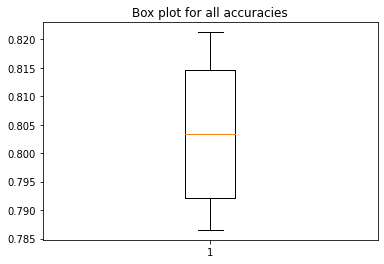

In [29]:
plt.title('Box plot for all accuracies')
plt.boxplot(gb_cv_results);

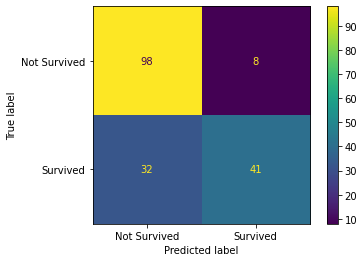

In [30]:
cm = confusion_matrix(y_test, 
                      gb_model.best_estimator_.predict(X_test),
                      labels=ada_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Survived','Survived'])
disp.plot()
plt.show()

|<h3 align="center">Adaboost</h3> |	<h3 align="center">Gradient Boost</h3>|
|-|-|
|An additive model where shortcomings of previous models are identified by high-weight data points.|An additive model where shortcomings of previous models are identified by the gradient.|
|The trees are usually grown as decision stumps. |The trees are grown to a greater depth usually ranging from 8 to 32 terminal nodes.|
|Each classifier has different weights assigned to the final prediction based on its performance.|All classifiers are weighed equally and their predictive capacity is restricted with learning rate to increase accuracy.|
|It gives weights to both classifiers and observations thus capturing maximum variance within data.	|It builds trees on previous classifier’s residuals thus capturing variance in data.|


<a href="https://www.analyticsvidhya.com/blog/2020/10/adaboost-and-gradient-boost-comparitive-study-between-2-popular-ensemble-model-techniques/">source</a>

|<h3 align="center">Bagging</h3> |	<h3 align="center">Boosting</h3>|
|-|-|
|<p>Various training data subsets are randomly drawn with replacement from the whole training dataset.|<p>Each new subset contains the components that were misclassified by previous models.|
|<p>Bagging attempts to tackle the over-fitting issue.	Boosting tries to reduce bias.|<p>If the classifier is unstable (high variance), then we need to apply bagging.|
|<p>If the classifier is steady and straightforward (high bias), then we need to apply boosting.|<p>Every model receives an equal weight.	Models are weighted by their performance.|
|<p>Objective to decrease variance, not bias.|<p>Objective to decrease bias, not variance.|
|<p>It is the easiest way of connecting predictions that belong to the same type.|<p>It is a way of connecting predictions that belong to the different types.|
|<p>Every model is constructed independently.|<p>New models are affected by the performance of the previously developed model.|
    
<a href="https://www.javatpoint.com/bagging-vs-boosting">source</a>

### 3) Stacked Generalization (Stacking)
- Stacking is a way to ensemble multiple classifications or regression model. 
- The point of stacking is to explore a space of different models for the same problem. 
- The idea is that you can attack a learning problem with different types of models which are capable to learn some part of the problem, but not the whole space of the problem. 
- So, you can build multiple different learners and you use them to build an intermediate prediction, one prediction for each learned model. Then you add a new model which learns from the intermediate predictions the same target.
- This final model is said to be stacked on the top of the others, hence the name. Thus, you might improve your overall performance, and often you end up with a model which is better than any individual intermediate model. Notice however, that it does not give you any guarantee, as is often the case with any machine learning technique.

- Stacking is the best choice because:
- Unlike bagging, in stacking, the models are typically different and fit on the same dataset.
- Unlike boosting, in stacking, a single model is used to learn how to best combine the predictions from the contributing models.

<img src="images/stacking.png"></img>

So, we have two levels:
- **Level_0 (Base models):**
    - Fit on the training data for all the folds of the whole data.
- **Level_1 (Meta model) :**
    - Learns how to best combine the predictions of the base models.
    - Is trained on the predictions made by the base models.
    
    
<a href="https://www.geeksforgeeks.org/ml-gradient-boosting/">geeksforgeeks</a>

In [37]:
# this's my simple implementation to the stacking algorithm using sklearn
# there already exist a sklearn implementtion (sklearn.ensemble.StackingClassifier)
# of course, sklearn is more sophisticated, but this simply for the purpose of putting my knowledge into practise!

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone

class StackingVotingdModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = len(self.base_models)
   
    # fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = StratifiedKFold(self.n_folds, shuffle=True,)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    # Do the predictions of all base models on the test data
    # then use the majority predictions as meta-features for the final prediction
    def predict(self, X):
        meta_features = np.column_stack([
            mode(np.column_stack([model.predict(X) for model in base_models]), axis=1)[0]
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [31]:
#Define our base and meta models for stacking
base_models = (gb_model.best_estimator_,
               ada_model.best_estimator_)

meta_model = RF_model.best_estimator_

#Building the stacking model
stack = StackingCVClassifier(classifiers=base_models,
                             meta_classifier=meta_model,
                             cv=kfolds)

#fitting the model to our data
stack_model = stack.fit(X_train, y_train)

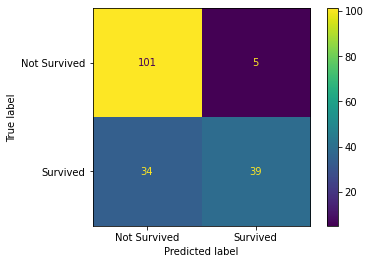

In [32]:
cm = confusion_matrix(y_test, 
                      stack_model.predict(X_test),
                      labels=ada_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Survived','Survived'])
disp.plot()
plt.show()

### 4) XGBoost
- A decision tree ensemble based on gradient boosting designed to be highly scalable. 
- Similarly to gradient boosting, XGBoost builds an additive expansion of the objective function by minimizing a loss function. 
- Extreme referes to the fact that the algorithms and methods have been customized to push the limit of what is possible for gradient boosting.
- Considering that XGBoost is focused only on decision trees as base classifiers, a variation of the loss function is used to control the complexity of the trees.
<img src="images/XGBoost.jpg">

Where T is the number of leaves of the tree and w are the output scores of the leaves. <br>
Higher values of γ result in simpler trees. The value of γ controls the minimum loss reduction gain needed to split an
internal node.
- This loss function can be integrated into the split criterion of decision
trees leading to a pre-pruning strategy

- In addition, XGBoost implements several methods to increment the training speed of decision trees not directly related to ensemble accuracy. 
- XGBoost focuses on reducing the computational complexity for finding the best split, which is the most time-consuming part of decision tree construction algorithms. 
- Instead of scanning all possible candidate splits, XGBoost implements a method based on percentiles of the data where only a subset of candidate splits is tested and their gain is computed using aggregated statistics. 
- Moreover, a sparsity-aware algorithm is used in XGBoost to effectively remove missing values from the computation of the loss gain of split candidates





- XGBoost Advantages:
    - In-build cross-validation capability.
    - Efficient handling of missing data.
    - Regularization for avoiding overfitting.
    - Cashe awareness and out-of-core computing.
    - Tree-Pruning using depth-first approach.
    - Parallelized tree building.
    

<a href="https://www.researchgate.net/publication/337048557_A_Comparative_Analysis_of_XGBoost">Source</a>

In [33]:
XGB_classifier = XGBClassifier()

folds = 5
param_comb = 5

# A parameter grid for XGBoost
params = {
        'n_estimators': np.arange(100, 600, 100),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(XGB_classifier, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc',
                                   cv=skf.split(X_train, y_train),
                                   verbose=-1)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001A8C3C27040>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interacti...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                   

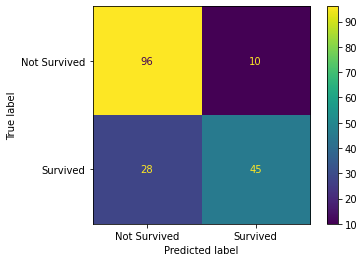

In [34]:
cm = confusion_matrix(y_test, 
                      random_search.best_estimator_.predict(X_test),
                      labels=random_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Survived','Survived'])
disp.plot()
plt.show()